<a href="https://colab.research.google.com/github/LeoMcBills/ML_humanEmotionDetection/blob/main/Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -q kaggle

In [ ]:
# !mkdir ~/.kaggle

In [ ]:
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 96% 296M/309M [00:02<00:00, 116MB/s]
100% 309M/309M [00:02<00:00, 117MB/s]


In [ ]:
# !unzip "/content/human-emotions-datasethes.zip" -d "/content/datasets"

Streaming output truncated to the last 5000 lines.
  inflating: /content/datasets/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/datasets/EmotionsD

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy,TopKCategoricalAccuracy, CategoricalAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.losses import CategoricalCrossentropy
import seaborn as sns
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
import albumentations as A

In [30]:
train_directory = "/content/datasets/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
}

In [15]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [16]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [17]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

# Dataset Visualization

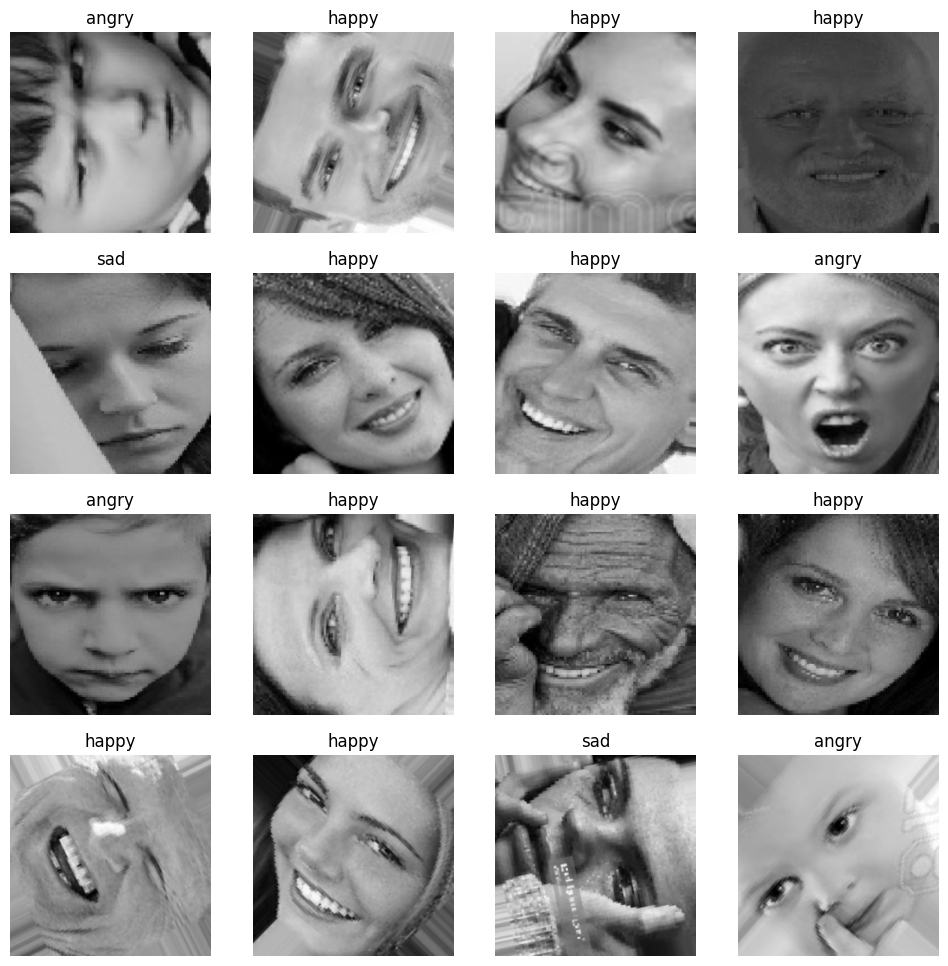

In [23]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

# DATA PREPARATION

In [19]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [20]:
val_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [21]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

# Modeling

In [28]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_20 (Ba  (None, 254, 254, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 127, 127, 6)       0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 127, 127, 6)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 16)      880       
                                                                 
 batch_normalization_21 (Ba  (None, 125, 125, 16)     

# Training

In [32]:
loss_function = CategoricalCrossentropy()
# loss_function = SparseCategoricalCrossentropy()

In [34]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name = "top_k_accuracy")]

In [35]:
lenet_model.compile(
    optimizer = Adam(learning_rate= CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = lenet_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
)

Epoch 1/20
213/213 [==============================] - 479s 2s/step - loss: 0.9226 - accuracy: 0.5793 - top_k_accuracy: 0.8287 - val_loss: 0.6887 - val_accuracy: 0.7300 - val_top_k_accuracy: 0.9038
Epoch 2/20
 56/213 [======>.......................] - ETA: 4:10 - loss: 0.7745 - accuracy: 0.6618 - top_k_accuracy: 0.8940